In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import mplleaflet
import pysal as ps
import geopandas as gpd
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import urllib
import urllib2
import time

from cStringIO import StringIO
import os
s = json.load(open(os.getenv('PUI2015')+'/nk1877.json'));
plt.rcParams.update(s)

import shapely.geometry as geom
start_time = time.time()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
dischargeQuery = '''
SELECT *
FROM nyc_discharge_2013
LIMIT 3
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)

##SQL query for retreiving the facility ids with higthest asthma count 

In [4]:
dischargeQuery = '''
SELECT ccs_diagnosis_description,facility_id,count(facility_id) as countId
FROM nyc_discharge_2013
WHERE LOWER(ccs_diagnosis_description) LIKE LOWER('%AsTHMA%')
GROUP BY ccs_diagnosis_description,facility_id
ORDER BY countId DESC
LIMIT 5
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
asthma       = pd.read_csv(dischargeStream)

In [5]:
asthma

,ccs_diagnosis_description,facility_id,countid
0,ASTHMA,1172,1878
1,ASTHMA,1169,1786
2,ASTHMA,1301,1057
3,ASTHMA,1165,920
4,ASTHMA,1178,890


##Retreiving information on facilities ID who's asthma patient count is maximum.

In [6]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
WHERE facility_id=1172 OR facility_id=1169 OR facility_id=1301 OR facility_id=1165 OR facility_id=1178
LIMIT 5

'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])
#facilities

###NYC Zip Code GeoJson File

In [7]:
nyczip= gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

Converting nyc zip code codes to EPSG : 2263 coordinate system for . 

In [8]:
sn=  gpd.GeoSeries(nyczip['geometry'])
sn.crs = {'init': 'epsg:4326', 'no_defs': True}
sn=sn.to_crs(epsg=2263)
nyczip['geometry']= sn

In [9]:
facility1= facilities[['facility_id','facility_name','facility_zip_code','geometry']]

In [10]:
tsk1= pd.merge(facility1, asthma, on='facility_id') 

In [11]:
tsk1=tsk1[['facility_id','facility_name','facility_zip_code','geometry','countid']]

In [12]:
s1=  gpd.GeoSeries(tsk1['geometry'])
s1.crs = {'init': 'epsg:4326', 'no_defs': True}
s1=s1.to_crs(epsg=2263)

In [13]:
tsk1['geometry']= s1

In [14]:
tsk1=tsk1.sort(columns='countid',ascending=False)

#Task 1.1
##Top five Facilities by facility Names

In [15]:
tsk1

,facility_id,facility_name,facility_zip_code,geometry,countid
2,1172,Lincoln Medical & Mental Health Center,10451,POINT (1005228.021716391 237182.1691768789),1878
1,1169,Montefiore Medical Center - Henry & Lucy Moses...,10467,POINT (1017278.463616514 259890.221163824),1786
4,1301,Kings County Hospital Center,11203,POINT (999760.5456509431 178215.3371727151),1057
0,1165,Jacobi Medical Center,10461,POINT (1026645.436320588 251684.2060465284),920
3,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,10457,POINT (1008724.037560453 246639.2619315821),890


In [16]:
crs = None
geo_df1 = gpd.GeoDataFrame(tsk1, crs=crs, geometry='geometry')

In [17]:
def getxy(pt):
    return pt.x, pt.y


#Task 1.2
Plotting scatter plot for point location of asthma facilities with highest asthma cases

In [18]:
#geo_df1.plot(scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd',size=50,linewidth=3.0,figsize=(15,15))
for i in range(5):
    x,y=getxy(geo_df1.geometry.centroid[i])
    plt.scatter(x,y,s=60)
# If we would like a base map, we will need to uncomment the below line
mplleaflet.display(crs=s1.crs)

##Retreiving highway information for zipcodes with highest asthma cases.

In [19]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
WHERE zipcode=10451 OR zipcode=10467 OR zipcode=11203 OR zipcode=10461 OR zipcode=10457
LIMIT 5
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
#zipcodes.head()

In [20]:
tsk2=['facility_id','facility_name','facility_zip_code','facility_latitude','facility_longitude','geometry','ccs_diagnosis_description']

In [21]:
tsk1.columns=['facility_id','facility_name','zipcode','geometry','countid']

In [22]:
tsktm= tsk1[['facility_id','facility_name','zipcode','countid']]

Merging information retreived from zip codes with table of asthma patient count. 

In [23]:
tsk2=pd.merge(zipcodes,tsktm,on='zipcode')

#Task 2.1
##Table with highway length and zipcodes

In [24]:
tsk2

,cartodb_id,geometry,highway_length,zipcode,facility_id,facility_name,countid
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467,1169,Montefiore Medical Center - Henry & Lucy Moses...,1786
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451,1172,Lincoln Medical & Mental Health Center,1878
2,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,10457,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,890
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461,1165,Jacobi Medical Center,920
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203,1301,Kings County Hospital Center,1057


In [25]:
s2=  gpd.GeoSeries(tsk2['geometry'])
s2.crs = {'init': 'epsg:4326', 'no_defs': True}
s2=s2.to_crs(epsg=2263)


In [26]:
tsk2['geometry']=s2

Retreiving all zip code and highway length information for plotting choropleth maps

In [27]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes1      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
#zipcodes1.head()

#Task 2.2

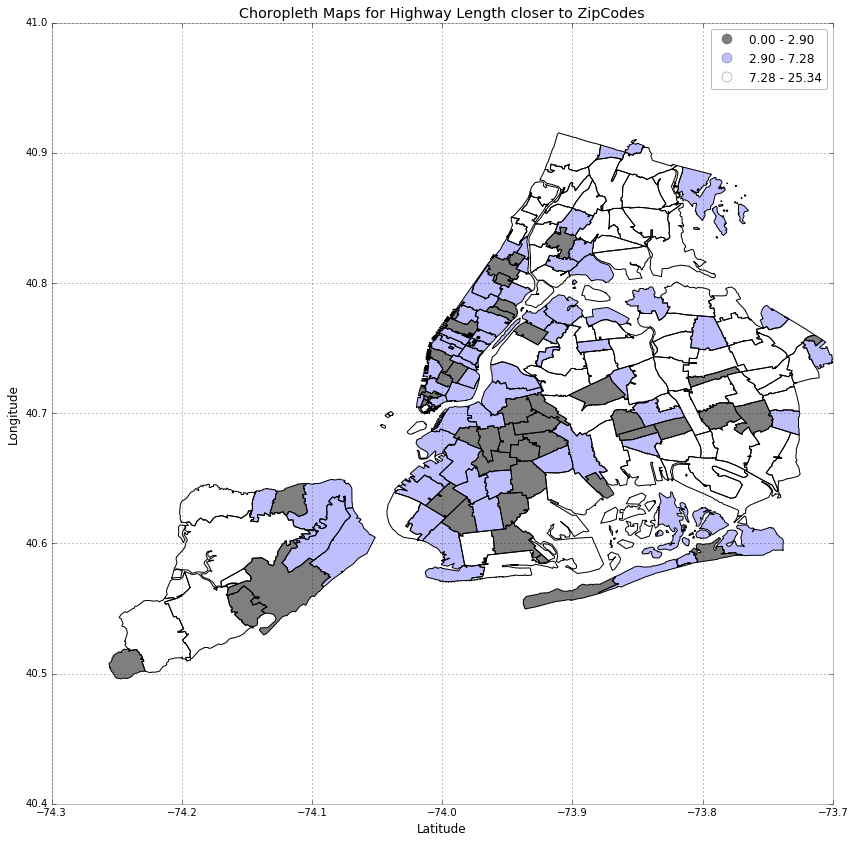

In [28]:
#plt.figure(figsize=(16, 14))
ax = zipcodes1.plot(column='highway_length', scheme='QUANTILES', k=3, colormap='gist_stern',figsize=(16, 14),legend=True)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Choropleth Maps for Highway Length closer to ZipCodes')

Loading shape files for parks

In [29]:
park=gpd.GeoDataFrame.from_file("DPR_ParksProperties_001/DPR_ParksProperties_001.shp")

In [30]:
def counttrue(arr):
    count=0
    for i in arr:
        if(i==True):
            count+=1
    return count

####Using "path" from matplotlib to use function which will find number of centroid of parks lying within the given radius of  zip code.

In [31]:
 from matplotlib.path import Path

Defining the function defineradius which will take index number of zipcode and array of points to return true false boolean array. True if given array of points lies within the range of zipcode radius.  

In [32]:
getxy(nyczip.geometry.centroid[41])

(1020062.8815872284, 259284.16978078088)

In [33]:
def defineradius(i,l,r):
    x,y=getxy(nyczip.geometry.centroid[i])
    patch = geom.Point(x,y).buffer(2)
    m=Path.circle(center=(x,y),radius=r)
    #print m
    pts=m.contains_points(l)
    return pts

Defining getdistance function which returs array of centroids of all the parks

In [34]:
def getdistancep(df):
    dftemp=pd.DataFrame({"lon":[x for x in range(df.shape[0])]})
    temp=dftemp['lon'].apply(lambda x: getxy(df.geometry.centroid[x])[0])
    tempA=dftemp['lon'].apply(lambda x: getxy(df.geometry.centroid[x])[1])
    ar=np.array([temp,tempA]).T
    return ar

assigning centroids of all the parks to variable y

In [35]:
y1=getdistancep(park)

defining function prkclosr which returns data frame of only those parks which lies within the given radius of given nyc zip index 

In [36]:
park1=park.copy()
def prkclosr(i,j,df,cent):
    k=pd.DataFrame({'Bool':defineradius(i,cent,j)})
    m=pd.concat([df,k],axis=1)
    m=m[m['Bool']==True]
    return m

In [37]:
##Converts postal code to index
def conv(g):
    s=str(g)
    return nyczip[nyczip['postalCode']==s].index[0]
    

In [38]:
type(park1)

geopandas.geodataframe.GeoDataFrame

##Created a function which inputs zipcode and using  functions defined above returns the sum of metrics of  park (i.e area of park divided by distance between centroid of the zipcode and nearest park ) of the given zip code. Function only sums the metrics of top 5 nearest park based on distance.

In [39]:
def distancefinder(i):
    i=conv(i)
    crs = None
    prk = gpd.GeoDataFrame(prkclosr(i,5000,park1,y1), crs=crs, geometry='geometry')
    dist=[prk.geometry.centroid[c].distance(nyczip.geometry.centroid[i]) for c in prk.index]
    area=[prk.geometry.area[c] for c in prk.index]
    m=[]
    c=[]
    for i in range(len(prk.index)):
        m.append(area[i]/dist[i])
        c.append(prk.index[i])
    k=pd.DataFrame({'metric':m},index=c)
    d=pd.DataFrame({'distance':dist},index=c)
    ar=pd.DataFrame({'area':area},index=c)
    kl= pd.concat([prk,k,d,ar],axis=1)
    kl= kl.sort(columns="distance")[:5]
    kl=kl.sum()['metric']
    return kl

In [40]:
distancefinder(10467)

521.79939928068893

In [41]:
l=[]
for k in tsk2['zipcode']:
    l.append(distancefinder(k))

In [42]:
tsk2['metric']= pd.DataFrame({"Metric":l})

#Task 4.1
###Table containing metric as value of impact of nearest parks

In [43]:
tsk2

,cartodb_id,geometry,highway_length,zipcode,facility_id,facility_name,countid,metric
0,106,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,10467,1169,Montefiore Medical Center - Henry & Lucy Moses...,1786,521.799399
1,111,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,10451,1172,Lincoln Medical & Mental Health Center,1878,931.517728
2,123,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,10457,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,890,927.008543
3,125,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,10461,1165,Jacobi Medical Center,920,2532.491114
4,195,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,11203,1301,Kings County Hospital Center,1057,146.254502


###Regression for regressors park impact and highway length

                            OLS Regression Results                            
Dep. Variable:                countid   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                 -0.155
Method:                 Least Squares   F-statistic:                    0.7312
Date:                Wed, 23 Dec 2015   Prob (F-statistic):              0.578
Time:                        07:29:39   Log-Likelihood:                -36.088
No. Observations:                   5   AIC:                             78.18
Df Residuals:                       2   BIC:                             77.00
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       1255.0672    439.950      2.

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


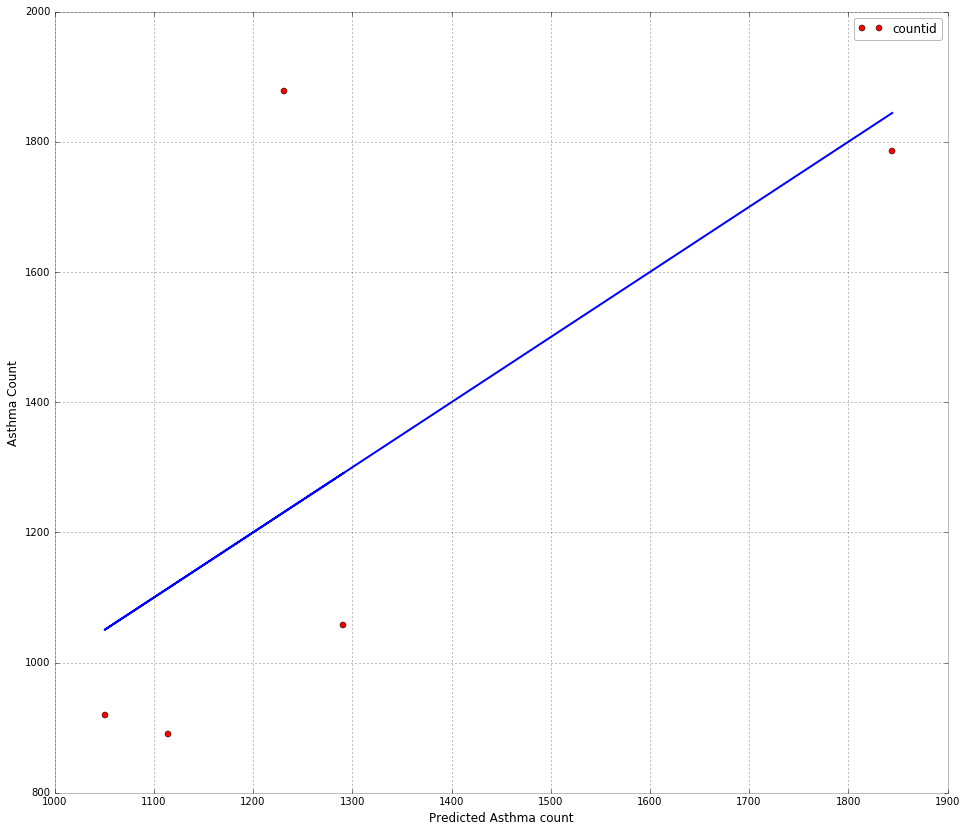

In [44]:
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "countid~ metric+ highway_length", data=tsk2,missing='drop').fit()
print(lm.summary())
lmy = lm.predict(tsk2)
plt.plot(lmy,tsk2.countid,'or')
plt.plot(lmy,lmy,'-b') 
plt.xlabel('Predicted Asthma count')
plt.ylabel('Asthma Count')
lgnd= plt.legend()

In [45]:
lp=[]
for k in nyczip['postalCode']:
    lp.append(distancefinder(k))

In [46]:
nyczip['metric']= pd.DataFrame({"Metric":lp})

#Task 4.2
##Plotting choropleth map of "access to green park metrics" per zip code

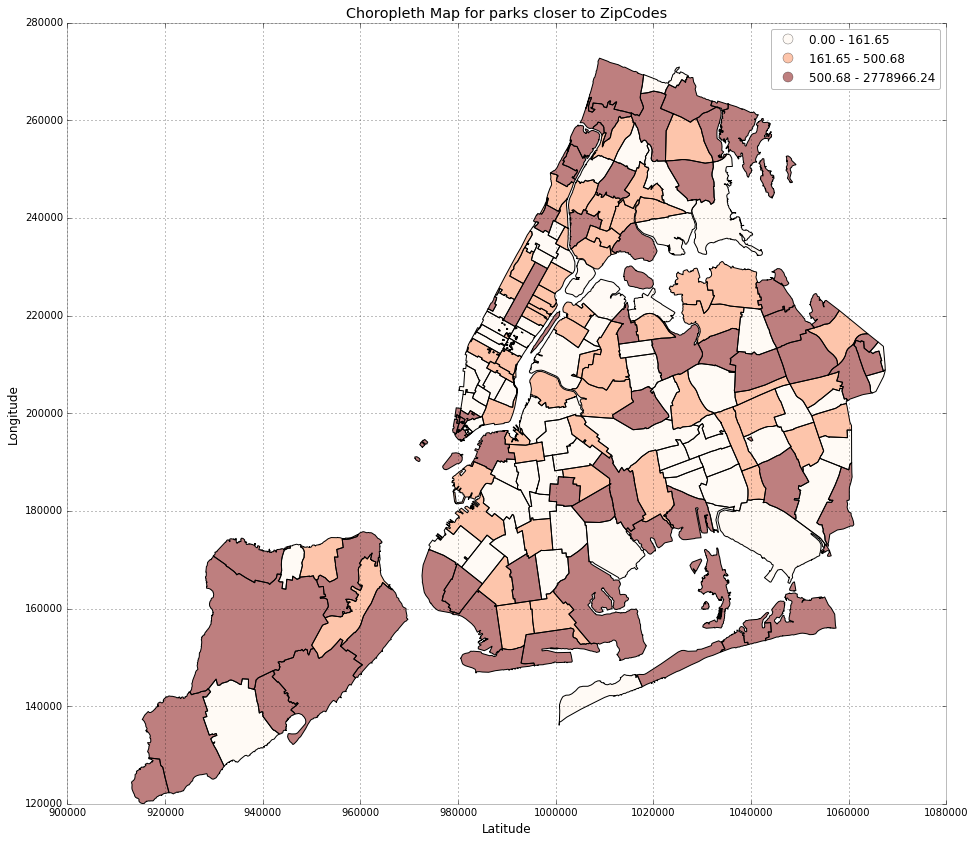

In [47]:
ax = nyczip.plot(column='metric', scheme='QUANTILES', k=3, colormap='OrRd',figsize=(16, 14),legend=True)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Choropleth Map for parks closer to ZipCodes')

##Loading shape file for precints

In [48]:
precints=gpd.GeoDataFrame.from_file("nypp_15d/nypp.shp")

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.



##Loading data for precints murder

In [49]:
pr= pd.read_excel("seven_major_felony_offenses_by_precinct_2000_2014.xls")

###Cleaning data to contain only 2013 murders

In [50]:
pre=pr[pr['Seven Major Felony Offenses']>0]

In [51]:
pre.columns=['Precinct','CRIME','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014']

In [52]:
pre=pre[pre.index!=1]
pre=pre.reset_index()

In [53]:
pr=pd.merge(pre,precints,on='Precinct')

In [54]:
pr=pr[['Precinct','2013','Shape_Area','Shape_Leng','geometry']]

In [55]:
crs = None
geo_df2 = gpd.GeoDataFrame(pr, crs=crs, geometry='geometry')

###getting centroinds of all the precincts

storing values of centroids in y2

In [56]:
y2=getdistancep(geo_df2)

## defining function similar as parks to return sum of murders divided by distance between centroids of precincts and centroid of zipcode 

In [57]:
def distancefinderp(i):
    i=conv(i)
    crs = None
    prk = gpd.GeoDataFrame(prkclosr(i,18000,geo_df2,y2), crs=crs, geometry='geometry')
    dist=[prk.geometry.centroid[c].distance(nyczip.geometry.centroid[i]) for c in prk.index]
    area=[prk.geometry.area[c] for c in prk.index]
    m=[]
    c=[]
    for i in range(len(prk.index)):
        m.append(area[i]/dist[i])
        c.append(prk.index[i])
    k=pd.DataFrame({'metric':m},index=c)
    d=pd.DataFrame({'distance':dist},index=c)
    ar=pd.DataFrame({'area':area},index=c)
    kl= pd.concat([prk,k,d,ar],axis=1)
    kl= kl.sort(columns="distance")[:5]
    kl['pre']=kl['2013']/kl['distance']
    kl=kl.sum()['pre']
    return kl

In [58]:
distancefinderp(10467)

0.0042331237901030551

In [59]:
l=[]
for k in tsk2['zipcode']:
    l.append(distancefinderp(k))

In [60]:
tsk2['murder']= pd.DataFrame({"murder":l})

#Task 3.1
##Table with murder as metric for crime near the zipcodes of asthma facilities.

In [61]:
tsk2

,cartodb_id,geometry,highway_length,zipcode,facility_id,facility_name,countid,metric,murder
0,106,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,10467,1169,Montefiore Medical Center - Henry & Lucy Moses...,1786,521.799399,0.004233
1,111,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,10451,1172,Lincoln Medical & Mental Health Center,1878,931.517728,0.007170
2,123,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,10457,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,890,927.008543,0.008587
3,125,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,10461,1165,Jacobi Medical Center,920,2532.491114,0.003204
4,195,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,11203,1301,Kings County Hospital Center,1057,146.254502,0.023157


In [62]:
nyczip

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,metric
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.874400,20624.692317,Queens,"POLYGON ((1020429.352826154 212241.6726792445,...",11372,64.913327
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.913900,23002.816039,Queens,"POLYGON ((1064411.491895817 212668.9825201534,...",11004,873.458448
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.412340,15749.161511,Queens,"POLYGON ((1067113.206636732 208617.6641792346,...",11040,76.604218
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.057700,35932.810639,Queens,"POLYGON ((1061076.633408061 214003.7997323968,...",11426,914.981556
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.594300,38693.565676,Queens,"POLYGON ((1036666.177307818 204261.4596370641,...",11365,3098.736718
5,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,42659399.898200,33755.870988,Queens,"POLYGON ((1015508.538520816 204354.0880607349,...",11373,79.461169
6,http://nyc.pediacities.com/Resource/PostalCode...,0,081,7,Floral Park,NY,36,9155180.262630,13594.924549,Queens,"POLYGON ((1067113.206636732 208617.6641792346,...",11001,43.784910
7,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,55587771.835000,36277.076839,Queens,"POLYGON ((1024087.848133824 207717.2624367269,...",11375,236.651796
8,http://nyc.pediacities.com/Resource/PostalCode...,0,081,9,Queens Village,NY,36,39568339.274800,31231.968593,Queens,"POLYGON ((1055835.628470141 207826.7802623207,...",11427,239.291737
9,http://nyc.pediacities.com/Resource/PostalCode...,0,081,10,Rego Park,NY,36,25203458.868900,26323.994393,Queens,"POLYGON ((1021799.012816478 206747.7204125646,...",11374,108.716567


In [63]:
lpre=[]
for k in nyczip['postalCode']:
    lpre.append(distancefinderp(k))

In [64]:
nyczip['metricpr']= pd.DataFrame({"metricpr":lpre})

#Task 3.2
##Choropleth map of baced on murder metrics

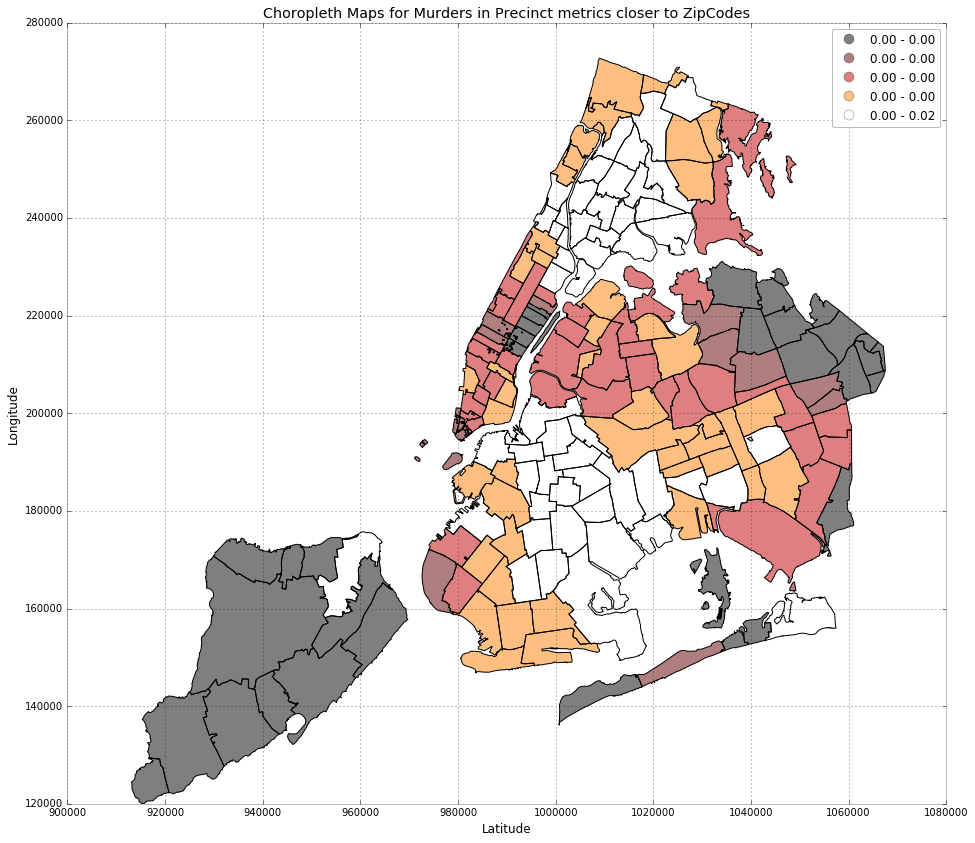

In [65]:
ax = nyczip.plot(column='metricpr', scheme='QUANTILES', k=5, colormap='gist_heat',figsize=(16, 14),legend=True)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Choropleth Maps for Murders in Precinct metrics closer to ZipCodes')
#Task 3.2
##Choropleth map of baced on murder metrics

In [66]:
three= pd.read_csv("311.csv")

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8,17,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [67]:
validcomplaints = ['UNSANITARY CONDITION','Dirty Conditions', 'Sewer',
                   'Hazardous Material','Construction',
                   'Indoor Air Quality','Indoor Sewage','Air Quality',
                   'HEATING','Industrial Waste','Mold','Asbestos',
                   'Sweeping/Missed-Inadequate','Smoking',
                   'Non-Residential Heat','Lead','Standing Water',
                    'Water Quality','Unsanitary Animal Facility',
                   'PAINT - PLASTER','GENERAL CONSTRUCTION']

In [68]:
three1=three[['Incident Zip','Complaint Type']]

In [69]:
ar=three1['Complaint Type'].isin(validcomplaints)

In [70]:
df= pd.DataFrame({'Bool':ar})

In [71]:
thre=pd.concat([df,three1],axis=1)

In [72]:
thre= thre[thre['Bool']==True]

In [73]:
def countzip(z):
    return (thre[thre['Incident Zip']==z].count()['Incident Zip'])*1
countzip(11201 )

574

In [74]:
lz=[]
for i in thre['Incident Zip'].unique(): 
    lz.append(countzip(i)*1.0/([three[three['Incident Zip']==i]])[0].shape[0])
d=pd.DataFrame({'zipmetric':lz,'Incident Zip':thre['Incident Zip'].unique()})

In [75]:
d=d[d['Incident Zip']>0]

In [76]:
d.columns=['zipcode','threemetrics']
tsk2 = pd.merge(tsk2,d, on='zipcode',how='inner') 

##task 6.1

In [77]:
tsk2

,cartodb_id,geometry,highway_length,zipcode,facility_id,facility_name,countid,metric,murder,threemetrics
0,106,(POLYGON ((1022045.174324712 265485.8146390664...,19.172015,10467,1169,Montefiore Medical Center - Henry & Lucy Moses...,1786,521.799399,0.004233,0.536208
1,111,"(POLYGON ((1003162.871453055 233644.226793992,...",7.914185,10451,1172,Lincoln Medical & Mental Health Center,1878,931.517728,0.007170,0.507375
2,123,(POLYGON ((1012600.268767681 251224.6751115753...,5.017199,10457,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,890,927.008543,0.008587,0.552963
3,125,(POLYGON ((1032365.388388703 243251.7094464547...,18.102258,10461,1165,Jacobi Medical Center,920,2532.491114,0.003204,0.287178
4,195,(POLYGON ((1000207.410375923 172073.7932331467...,2.212840,11203,1301,Kings County Hospital Center,1057,146.254502,0.023157,0.429061


In [78]:
d.columns=['postalCode','threemetrics'] 

In [79]:
nyczip = pd.merge(nyczip,d,on='postalCode')

##Task 6.2

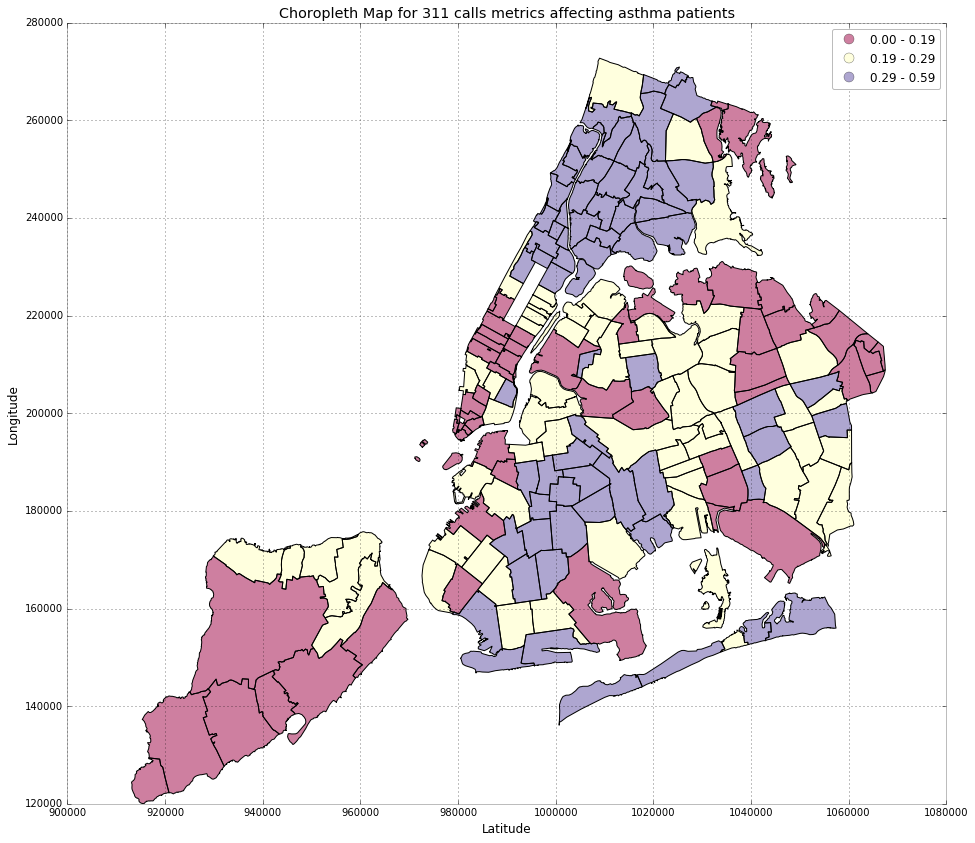

In [80]:
ax = nyczip.plot(column='threemetrics', scheme='QUANTILES', k=3, colormap='Spectral',figsize=(16, 14),legend=True)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Choropleth Map for 311 calls metrics affecting asthma patients')

In [81]:
from scipy.cluster.vq import whiten
ar1=tsk2[['countid','metric','murder','threemetrics','highway_length']]
#ar =ar.as_matrix()
w = whiten(ar1)

In [82]:
ts=pd.DataFrame({'hospital':w[0],'park':w[1],'murder':w[2],'three11':w[3],'highway_length':w[4]})

In [83]:
ts

,highway_length,hospital,murder,park,three11
0,2.435669,4.115520,2.050847,4.327518,2.119977
1,0.179608,0.640797,1.138414,1.143952,3.110030
2,3.211962,0.587158,1.191018,0.994504,0.444394
3,4.402716,5.502183,5.674111,5.206316,2.946816
4,0.320452,2.776388,0.726564,1.146090,2.621471


#Part 6
##Multivariate Regression of regressors park metric, murder metric, highway against asthma patient count

In [84]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 5 columns):
highway_length    5 non-null float64
hospital          5 non-null float64
murder            5 non-null float64
park              5 non-null float64
three11           5 non-null float64
dtypes: float64(5)
memory usage: 240.0 bytes


                            OLS Regression Results                            
Dep. Variable:               hospital   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     4.961
Date:                Wed, 23 Dec 2015   Prob (F-statistic):              0.323
Time:                        07:33:56   Log-Likelihood:                -5.5271
No. Observations:                   5   AIC:                             19.05
Df Residuals:                       1   BIC:                             17.49
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
murder             0.0916      0.920      0.

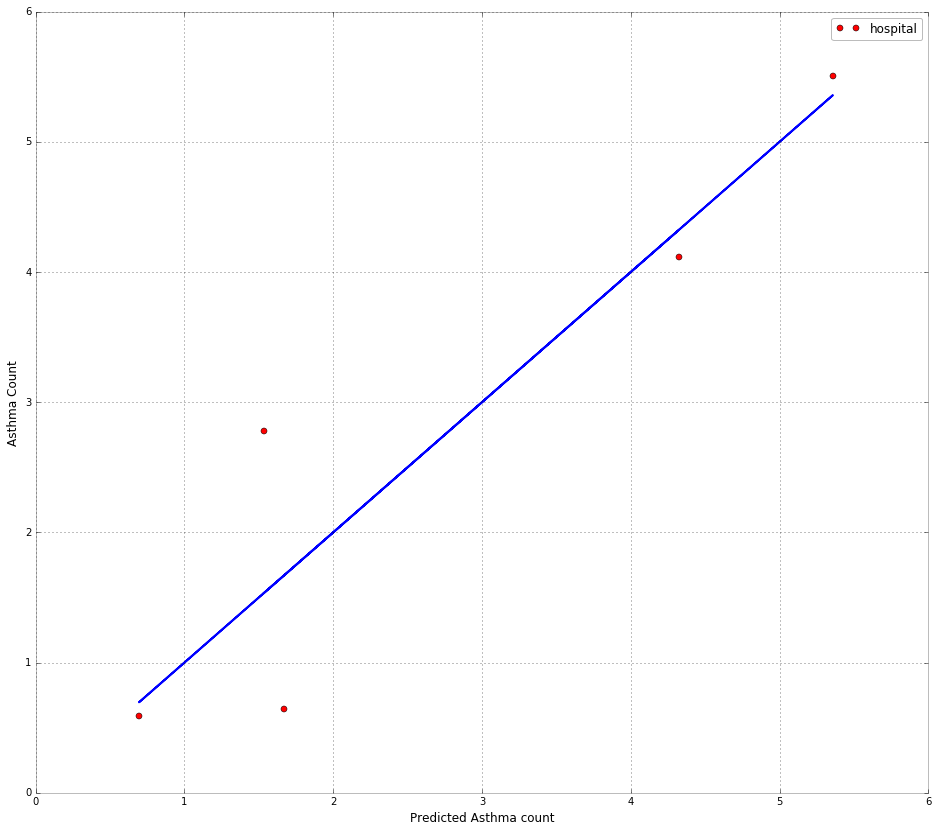

In [85]:
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "hospital~ murder+ highway_length+ three11+ park -1", data=ts).fit()
print(lm.summary())
lmy = lm.predict(ts)
plt.plot(lmy,ts.hospital,'or')
plt.plot(lmy,lmy,'-b') 
plt.xlabel('Predicted Asthma count')
plt.ylabel('Asthma Count')
lgnd= plt.legend()
 

R square value is high suggesting good fit but when we look at the coefficients it could be seen apart from highway everything else has positive relation. It means asthma patients decrease with increase is highways, although rest everything increases as number of asthma patients increses including increase in murder, parks and 311 calls.
Although when we look at p values it could be noticed that none of the values are significant and confidence interval is too high. Therefore it could be assumed that model is not good.

##Organizing and cleaning data for clustering

In [86]:
nyclst= nyczip[['postalCode','metric','metricpr','geometry','threemetrics']]

In [87]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])

In [88]:
zipcodes= zipcodes[['highway_length',"zipcode"]]

In [89]:
nyclst.columns=['zipcode','metric','metricpr','geometry','threemetrics']

In [90]:
nyclst["zipcode"]=nyclst["zipcode"].convert_objects(convert_numeric=True)

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
nyclst= pd.merge(zipcodes,nyclst,on='zipcode',how='inner')

In [92]:
crs = None
geo_df3 = gpd.GeoDataFrame(nyclst, crs=crs, geometry='geometry')

In [93]:
len(nyclst['zipcode'].unique())

181

In [94]:
nyclst1= nyclst[['highway_length','metric','metricpr','threemetrics']]

##Multiplying weights with coefficients

In [95]:
nyclst1["highway_length"] = nyclst1["highway_length"]*-0.1346
nyclst1["metric"] = nyclst1["metric"]*0.9525
nyclst1["metricpr"] = nyclst1["metricpr"]* 0.0916
nyclst1["threemetrics"] = nyclst1["threemetrics"]* 0.1602

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

##Converting the table to matrix for clustering

In [96]:
d2_array = nyclst1.as_matrix()

In [97]:
from scipy.cluster.vq import whiten
w = whiten(d2_array)

In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
score = np.zeros(9)
for k in range(0, 9):
    est = KMeans(n_clusters = k+2, n_init = 10)
    est.fit(w)
    score[k]= silhouette_score(w, est.labels_)
    print ('At {0} clusters, silhouette score is {1}'.format(k+2, score[k])) 

At 2 clusters, silhouette score is 0.35766037647
At 3 clusters, silhouette score is 0.393468850432
At 4 clusters, silhouette score is 0.384120984625
At 5 clusters, silhouette score is 0.363775267866
At 6 clusters, silhouette score is 0.30719817347
At 7 clusters, silhouette score is 0.32219333543
At 8 clusters, silhouette score is 0.312102397163
At 9 clusters, silhouette score is 0.300391945434
At 10 clusters, silhouette score is 0.312871358263


In [99]:
from sklearn.cluster import k_means

est=k_means(w,n_clusters = 5)

###Although silhoutte score is suggesting 3 clusters 5 clusters are choosen for better spatial view

In [100]:
geo_df3['cluster']= pd.DataFrame(est[1])

#Task 7
##Plotting spatial clustering

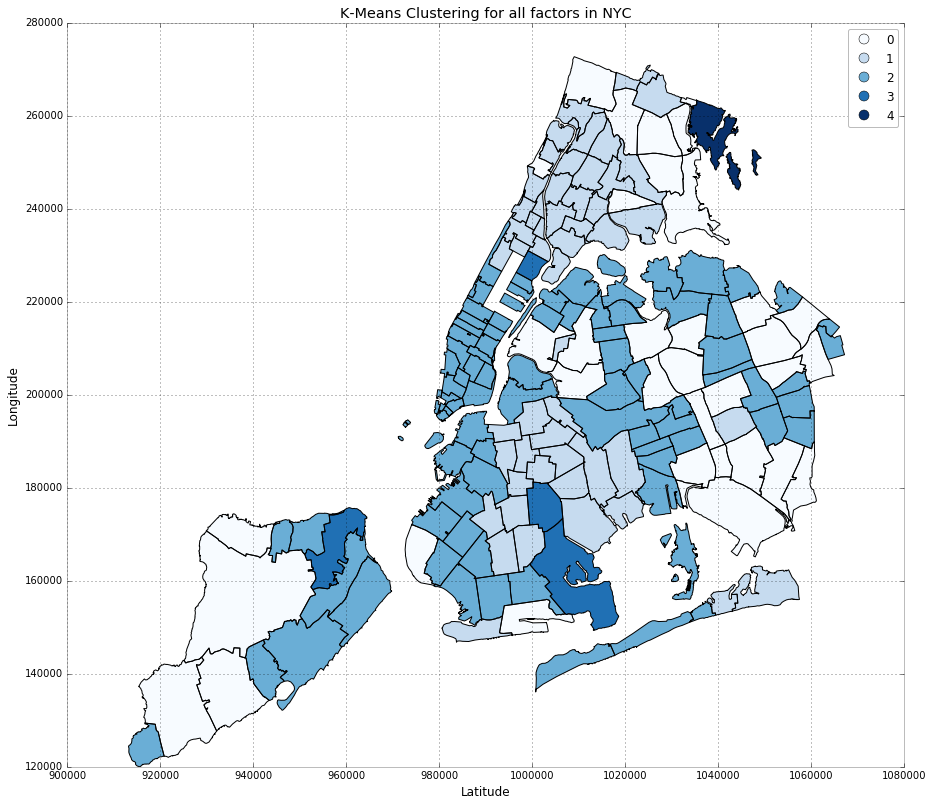

In [101]:
geo_df3.plot(column='cluster', categorical=True, legend=True, alpha=1, colormap='Blues',figsize=(15,15))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('K-Means Clustering for all factors in NYC')

it could be seen on clustering that 5 clusters are formed with 1 cluster in staten island due to effect of factors namely park, murder, 311 calls and highway length.1 at downtown with lower impact, 1 with slightly little higher impact at uptown.Corner of brooklyn with higher color showing higher impact of factors.

In [102]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 526.873283863 seconds ---
